# What-If Analysis: Exploring Multiple Scenarios

This notebook demonstrates **what-if analysis** - a validation technique that explores how model recommendations change across different complete scenarios.

Understanding what-if analysis is essential because:
- **The future is uncertain** - you cannot predict exactly what will happen
- **Multiple scenarios are possible** - optimistic, realistic, and pessimistic futures
- **What-if analysis prepares you** - you develop plans for different futures
- **You're ready when reality arrives** - you have contingency plans ready


## Key Concepts

**What-If Analysis** explores complete scenarios:
- You define multiple "what if" situations with different assumptions
- You run the model for each scenario to see what it recommends
- You compare recommendations across scenarios to understand differences
- You prepare contingency plans for each scenario

**Why It Matters**:
- **You cannot predict the future** - but you can prepare for multiple futures
- **Different scenarios need different plans** - what works in one scenario may fail in another
- **Preparation prevents panic** - when reality arrives, you're ready
- **Balanced analysis includes optimistic AND pessimistic scenarios** - don't just plan for good times

**Critical insight**: What-if analysis turns uncertainty into preparedness by exploring multiple futures and preparing for each.


## Scenario: Inventory Planning for Uncertain Demand

You manage inventory for a retail store. You need to decide how much inventory to order for the holiday season.

**The Challenge**: You don't know what demand will be. Three scenarios are possible:
- **Optimistic**: Strong economy, successful marketing, high consumer confidence → High demand
- **Realistic**: Normal economy, average marketing, normal consumer confidence → Normal demand
- **Pessimistic**: Weak economy, marketing underperforms, low consumer confidence → Low demand

**The Question**: What should you order in each scenario? How different are the recommendations?

**Decision variables**: How much inventory to order

**Scenarios to explore**: Optimistic, Realistic, Pessimistic


## Step 1: Install Required Packages (Colab)

If you're running this notebook in Google Colab, you need to install the `pulp` package first. This cell can be skipped if running locally and the package is already installed.


In [1]:
# Install pulp package (required for optimization)
# This is needed in Google Colab; can be skipped if already installed locally
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, value


## Step 3: Define Scenarios

Let's define three complete scenarios with different assumptions:


In [3]:
# Define three scenarios
scenarios = {
    'Optimistic': {
        'demand': 1500,      # High demand
        'unit_cost': 20,     # Lower costs (bulk discounts)
        'storage_cost': 2,   # Lower storage costs
        'selling_price': 50, # Higher selling price
        'description': 'Strong economy, successful marketing, high consumer confidence'
    },
    'Realistic': {
        'demand': 1000,      # Normal demand
        'unit_cost': 25,     # Normal costs
        'storage_cost': 3,   # Normal storage costs
        'selling_price': 45, # Normal selling price
        'description': 'Normal economy, average marketing, normal consumer confidence'
    },
    'Pessimistic': {
        'demand': 600,       # Low demand
        'unit_cost': 30,     # Higher costs (smaller orders)
        'storage_cost': 4,   # Higher storage costs
        'selling_price': 40, # Lower selling price (discounts needed)
        'description': 'Weak economy, marketing underperforms, low consumer confidence'
    }
}

# Display scenarios
scenarios_df = pd.DataFrame(scenarios).T
print("WHAT-IF SCENARIOS:")
print("=" * 80)
for scenario_name, scenario_data in scenarios.items():
    print(f"\n{scenario_name.upper()} SCENARIO:")
    print(f"  {scenario_data['description']}")
    print(f"  Demand: {scenario_data['demand']} units")
    print(f"  Unit Cost: ${scenario_data['unit_cost']}")
    print(f"  Storage Cost: ${scenario_data['storage_cost']} per unit")
    print(f"  Selling Price: ${scenario_data['selling_price']}")


WHAT-IF SCENARIOS:

OPTIMISTIC SCENARIO:
  Strong economy, successful marketing, high consumer confidence
  Demand: 1500 units
  Unit Cost: $20
  Storage Cost: $2 per unit
  Selling Price: $50

REALISTIC SCENARIO:
  Normal economy, average marketing, normal consumer confidence
  Demand: 1000 units
  Unit Cost: $25
  Storage Cost: $3 per unit
  Selling Price: $45

PESSIMISTIC SCENARIO:
  Weak economy, marketing underperforms, low consumer confidence
  Demand: 600 units
  Unit Cost: $30
  Storage Cost: $4 per unit
  Selling Price: $40


## Step 4: Create Inventory Optimization Model

We'll create a model that minimizes total cost (purchase + storage) while meeting demand:


In [4]:
def solve_inventory_model(demand, unit_cost, storage_cost, selling_price, max_storage=2000):
    """
    Solve inventory optimization model.
    Objective: Minimize total cost (purchase + storage)
    Constraint: Must meet demand
    Returns: (order_quantity, total_cost, total_revenue, net_profit)
    """
    # Create model
    model = LpProblem("Inventory_Optimization", LpMinimize)
    
    # Decision variable: How much to order
    order_quantity = LpVariable("order_quantity", lowBound=0, cat='Integer')
    
    # Objective: Minimize total cost (purchase + storage)
    # Storage cost applies to all ordered units (simplified model)
    total_cost = unit_cost * order_quantity + storage_cost * order_quantity
    model += total_cost, "Total_Cost"
    
    # Constraint: Must meet demand
    model += order_quantity >= demand, "Meet_Demand"
    
    # Constraint: Storage capacity
    model += order_quantity <= max_storage, "Storage_Capacity"
    
    # Solve
    model.solve()
    
    # Calculate results
    order_qty = value(order_quantity)
    total_cost_val = value(model.objective)
    total_revenue = selling_price * min(order_qty, demand)  # Revenue from sales
    net_profit = total_revenue - total_cost_val
    
    return (order_qty, total_cost_val, total_revenue, net_profit)


In [5]:
# Run model for each scenario
results = {}

for scenario_name, scenario_data in scenarios.items():
    order_qty, total_cost, total_revenue, net_profit = solve_inventory_model(
        scenario_data['demand'],
        scenario_data['unit_cost'],
        scenario_data['storage_cost'],
        scenario_data['selling_price']
    )
    
    results[scenario_name] = {
        'Demand': scenario_data['demand'],
        'Unit Cost': scenario_data['unit_cost'],
        'Storage Cost': scenario_data['storage_cost'],
        'Selling Price': scenario_data['selling_price'],
        'Order Quantity': order_qty,
        'Total Cost': total_cost,
        'Total Revenue': total_revenue,
        'Net Profit': net_profit
    }

# Create results table
results_df = pd.DataFrame(results).T
print("WHAT-IF ANALYSIS RESULTS:")
print("=" * 80)
display(results_df.round(0))


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/251dbce99c5d42a8ad1976dc8ac09492-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/251dbce99c5d42a8ad1976dc8ac09492-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 13 RHS
At line 16 BOUNDS
At line 18 ENDATA
Problem MODEL has 2 rows, 1 columns and 2 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 33000 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 33000 to -1.79769e+308
Probing was tried 0 times and created 0 c

,Demand,Unit Cost,Storage Cost,Selling Price,Order Quantity,Total Cost,Total Revenue,Net Profit
Optimistic,1500.0,20.0,2.0,50.0,1500.0,33000.0,75000.0,42000.0
Realistic,1000.0,25.0,3.0,45.0,1000.0,28000.0,45000.0,17000.0
Pessimistic,600.0,30.0,4.0,40.0,600.0,20400.0,24000.0,3600.0


## Step 6: Visualize Scenario Comparisons

Let's visualize how recommendations differ across scenarios:


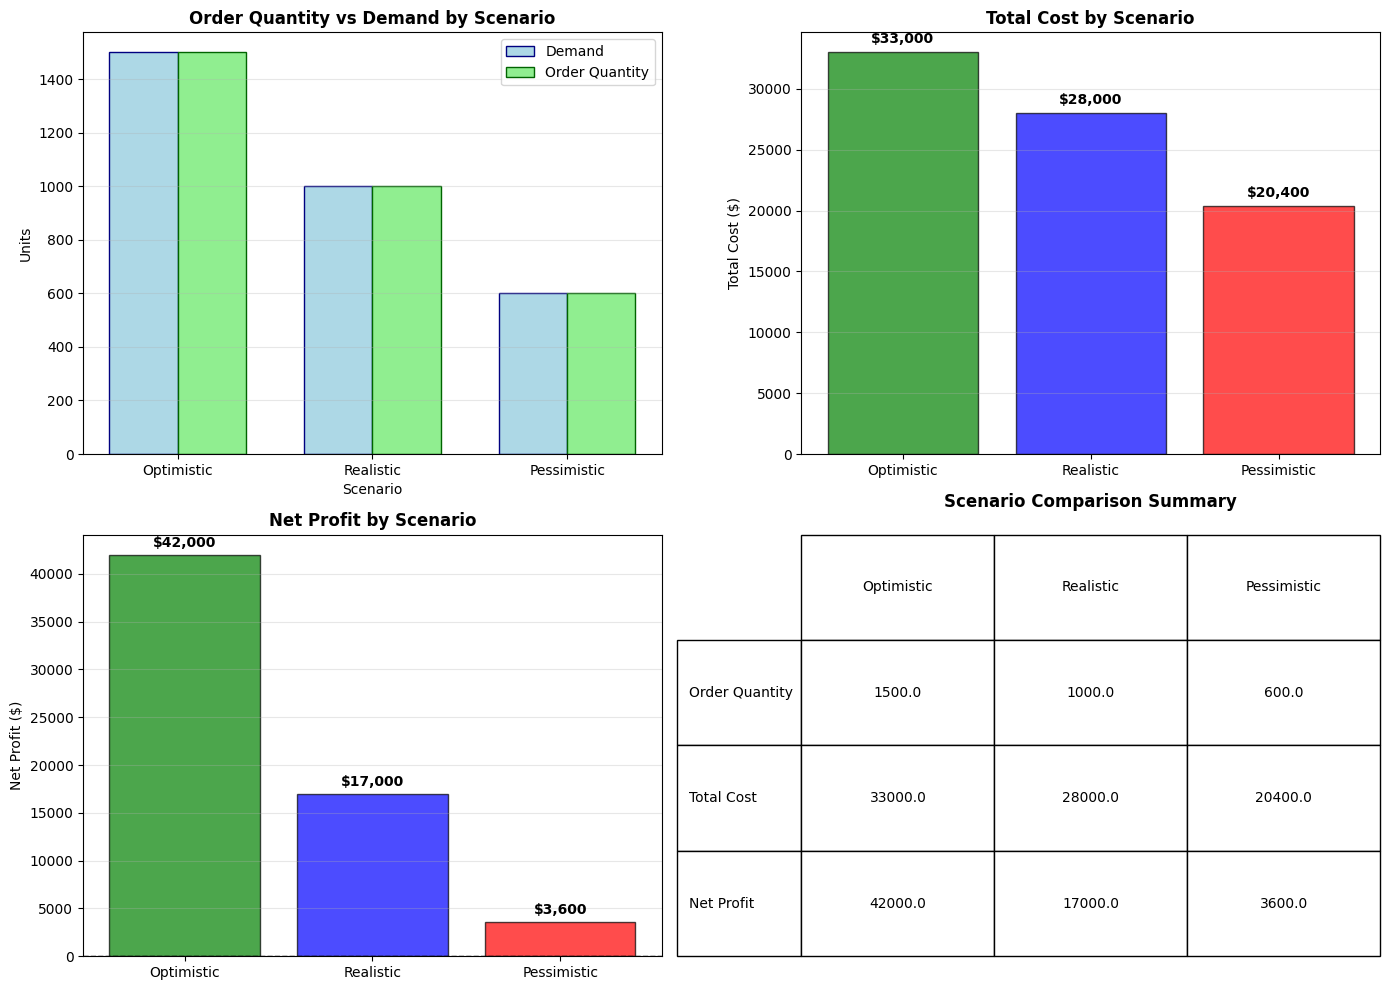

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

scenario_names = list(results_df.index)
colors = ['green', 'blue', 'red']

# Plot 1: Order Quantity vs Demand
ax1 = axes[0, 0]
x_pos = np.arange(len(scenario_names))
width = 0.35

demand_values = [results_df.loc[s, 'Demand'] for s in scenario_names]
order_values = [results_df.loc[s, 'Order Quantity'] for s in scenario_names]

ax1.bar(x_pos - width/2, demand_values, width, label='Demand', color='lightblue', edgecolor='navy')
ax1.bar(x_pos + width/2, order_values, width, label='Order Quantity', color='lightgreen', edgecolor='darkgreen')
ax1.set_xlabel('Scenario')
ax1.set_ylabel('Units')
ax1.set_title('Order Quantity vs Demand by Scenario', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(scenario_names)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Total Cost by Scenario
ax2 = axes[0, 1]
cost_values = [results_df.loc[s, 'Total Cost'] for s in scenario_names]
bars = ax2.bar(scenario_names, cost_values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Total Cost ($)')
ax2.set_title('Total Cost by Scenario', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar, cost in zip(bars, cost_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
             f'${cost:,.0f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Net Profit by Scenario
ax3 = axes[1, 0]
profit_values = [results_df.loc[s, 'Net Profit'] for s in scenario_names]
bars = ax3.bar(scenario_names, profit_values, color=colors, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Net Profit ($)')
ax3.set_title('Net Profit by Scenario', fontweight='bold')
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.grid(axis='y', alpha=0.3)
for bar, profit in zip(bars, profit_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (500 if profit > 0 else -2000),
             f'${profit:,.0f}', ha='center', va='bottom' if profit > 0 else 'top', fontweight='bold')

# Plot 4: Comparison Table Visualization
ax4 = axes[1, 1]
ax4.axis('off')
comparison_data = results_df[['Order Quantity', 'Total Cost', 'Net Profit']].T
table = ax4.table(cellText=comparison_data.values.round(0),
                  rowLabels=comparison_data.index,
                  colLabels=comparison_data.columns,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
ax4.set_title('Scenario Comparison Summary', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


In [7]:
# Calculate differences
realistic_order = results_df.loc['Realistic', 'Order Quantity']
optimistic_order = results_df.loc['Optimistic', 'Order Quantity']
pessimistic_order = results_df.loc['Pessimistic', 'Order Quantity']

print("SCENARIO DIFFERENCES:")
print("=" * 80)
print(f"\nOrder Quantity:")
print(f"  Optimistic: {optimistic_order:.0f} units")
print(f"  Realistic: {realistic_order:.0f} units")
print(f"  Pessimistic: {pessimistic_order:.0f} units")
print(f"  Range: {optimistic_order - pessimistic_order:.0f} units ({((optimistic_order - pessimistic_order)/realistic_order*100):.1f}% of realistic)")

print(f"\nTotal Cost:")
print(f"  Optimistic: ${results_df.loc['Optimistic', 'Total Cost']:,.0f}")
print(f"  Realistic: ${results_df.loc['Realistic', 'Total Cost']:,.0f}")
print(f"  Pessimistic: ${results_df.loc['Pessimistic', 'Total Cost']:,.0f}")

print(f"\nNet Profit:")
print(f"  Optimistic: ${results_df.loc['Optimistic', 'Net Profit']:,.0f}")
print(f"  Realistic: ${results_df.loc['Realistic', 'Net Profit']:,.0f}")
print(f"  Pessimistic: ${results_df.loc['Pessimistic', 'Net Profit']:,.0f}")

# Key insights
print(f"\nKEY INSIGHTS:")
print(f"  • Recommendations vary significantly across scenarios")
print(f"  • Order quantity ranges from {pessimistic_order:.0f} to {optimistic_order:.0f} units")
print(f"  • You need different plans for different scenarios")
print(f"  • Consider a flexible ordering strategy that can adapt")


SCENARIO DIFFERENCES:

Order Quantity:
  Optimistic: 1500 units
  Realistic: 1000 units
  Pessimistic: 600 units
  Range: 900 units (90.0% of realistic)

Total Cost:
  Optimistic: $33,000
  Realistic: $28,000
  Pessimistic: $20,400

Net Profit:
  Optimistic: $42,000
  Realistic: $17,000
  Pessimistic: $3,600

KEY INSIGHTS:
  • Recommendations vary significantly across scenarios
  • Order quantity ranges from 600 to 1500 units
  • You need different plans for different scenarios
  • Consider a flexible ordering strategy that can adapt


## Step 8: Develop Contingency Plans

Based on the what-if analysis, let's develop contingency plans:


In [8]:
# Develop contingency plans
contingency_plans = pd.DataFrame({
    'Scenario': ['Optimistic', 'Realistic', 'Pessimistic'],
    'Order Quantity': [optimistic_order, realistic_order, pessimistic_order],
    'Action Plan': [
        'Order maximum early, prepare for high sales',
        'Order standard amount, monitor early sales',
        'Order minimum, prepare for markdowns'
    ],
    'Trigger': [
        'Early sales > 120% of forecast',
        'Early sales 80-120% of forecast',
        'Early sales < 80% of forecast'
    ],
    'Risk': [
        'Risk: Excess inventory if wrong',
        'Risk: Stockouts if demand higher',
        'Risk: Lost sales if demand higher'
    ]
})

print("CONTINGENCY PLANS:")
print("=" * 80)
display(contingency_plans)

print("\nSTRATEGIC RECOMMENDATION:")
print("  Start with realistic order, but:")
print("  • Prepare to increase if early sales are strong (optimistic scenario)")
print("  • Prepare to reduce if early sales are weak (pessimistic scenario)")
print("  • Monitor early sales closely to identify which scenario is unfolding")


CONTINGENCY PLANS:


,Scenario,Order Quantity,Action Plan,Trigger,Risk
0,Optimistic,1500.0,"Order maximum early, prepare for high sales",Early sales > 120% of forecast,Risk: Excess inventory if wrong
1,Realistic,1000.0,"Order standard amount, monitor early sales",Early sales 80-120% of forecast,Risk: Stockouts if demand higher
2,Pessimistic,600.0,"Order minimum, prepare for markdowns",Early sales < 80% of forecast,Risk: Lost sales if demand higher



STRATEGIC RECOMMENDATION:
  Start with realistic order, but:
  • Prepare to increase if early sales are strong (optimistic scenario)
  • Prepare to reduce if early sales are weak (pessimistic scenario)
  • Monitor early sales closely to identify which scenario is unfolding


## Step 9: Interactive Exploration

Try creating your own scenarios and see how recommendations change:


In [9]:
# Create a custom scenario
custom_scenario = {
    'demand': 1200,      # Try different values
    'unit_cost': 22,     # Try different values
    'storage_cost': 2.5, # Try different values
    'selling_price': 48  # Try different values
}

custom_order, custom_cost, custom_revenue, custom_profit = solve_inventory_model(
    custom_scenario['demand'],
    custom_scenario['unit_cost'],
    custom_scenario['storage_cost'],
    custom_scenario['selling_price']
)

print("CUSTOM SCENARIO:")
print("=" * 80)
print(f"  Demand: {custom_scenario['demand']} units")
print(f"  Unit Cost: ${custom_scenario['unit_cost']}")
print(f"  Storage Cost: ${custom_scenario['storage_cost']}")
print(f"  Selling Price: ${custom_scenario['selling_price']}")
print(f"\nRECOMMENDATION:")
print(f"  Order Quantity: {custom_order:.0f} units")
print(f"  Total Cost: ${custom_cost:,.0f}")
print(f"  Total Revenue: ${custom_revenue:,.0f}")
print(f"  Net Profit: ${custom_profit:,.0f}")

# Compare to realistic scenario
print(f"\nCOMPARED TO REALISTIC SCENARIO:")
print(f"  Order difference: {custom_order - realistic_order:.0f} units")
print(f"  Cost difference: ${custom_cost - results_df.loc['Realistic', 'Total Cost']:,.0f}")
print(f"  Profit difference: ${custom_profit - results_df.loc['Realistic', 'Net Profit']:,.0f}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/a133cad6e2b94ac4be0f239e751ad78b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/a133cad6e2b94ac4be0f239e751ad78b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 13 RHS
At line 16 BOUNDS
At line 18 ENDATA
Problem MODEL has 2 rows, 1 columns and 2 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 29400 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 29400 to -1.79769e+308
Probing was tried 0 times and created 0 c

## Summary: What-If Analysis

**What We Learned**:
- **What-if analysis** explores multiple complete scenarios to see how recommendations change
- **Different scenarios need different plans** - what works in one scenario may fail in another
- **Preparation prevents panic** - when reality arrives, you're ready with contingency plans
- **Balanced analysis includes optimistic AND pessimistic scenarios** - don't just plan for good times

**Key Insights**:
1. **Explore multiple futures**: Define optimistic, realistic, and pessimistic scenarios
2. **Run model for each scenario**: See what the model recommends in each case
3. **Compare recommendations**: Understand how different scenarios lead to different plans
4. **Develop contingency plans**: Prepare for each scenario so you're ready when reality arrives

**Practical Application**:
- Always perform what-if analysis when uncertainty is high
- Include both optimistic and pessimistic scenarios (not just optimistic)
- Develop contingency plans for each scenario
- Monitor early indicators to identify which scenario is unfolding
- Be flexible and ready to adapt when reality differs from assumptions
